# Importing libraires

In [3]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras import layers
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dashazorkot/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dashazorkot/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
!pip install -U spaCy
!python -m spacy download fr_core_news_md
import spacy
nlp = spacy.load("fr_core_news_md")

     |████████████████████████████████| 46.9 MB 12.4 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


# Importing the dataset

- df1 is the dataset during the 2017 French elections: we trained our models with it
<br>
- we then used the most performant one on a more recent time frame df2 to have an insight on what's going on in French politics at the moment

In [6]:
# import data from excel file

def create_data_set(file_name):
    df = pd.read_excel(file_name)
    df['datetime']=pd.to_datetime(df['Date'])
    df['ts'] = df[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
    df=df.drop(['datetime','Date'],axis=1)
    df['label'] = df['label'].map({'NEGATIVE': 0, 'POSITIVE': 1}).astype(int)
    df['Likes']=df['Likes'].fillna(0)
    df['Retweets']=df['Retweets'].fillna(int(0))
    return df


In [8]:
df1 = create_data_set("dataset2017(nacron+lepen).xlsx")

# Preprocessing

In [5]:
def clean_special(text): # cleans special characters
    text=text.replace("'","' ")
    text=text.replace("’","' ")
    return re.sub('[^a-zA-Z0-9éèêàùûëâ\']',' ',text)

def clean_url(text):#remove url
    return re.sub(r'http\S+', '',text)

def clean_lower_case(text): #remove capital letters
    return str(text).lower()


def tokenize(text): # tokenization
    return word_tokenize(text)

def getStopWords():
    res =  list(fr_stop)
    to_remove =['aucun', 'aucune', 'suffisant', 'excepté', 'sinon','malgre','outre', 'pas', 'plus','encore','sauf','néanmoins','seulement','nul','plutôt', 'moindres' ]
    for e in to_remove:
        res.remove(e)
    return res

def removingStopWords(token): #remove stop words from list of tweet
    final_stopwords_list = getStopWords()
    return [item for item in token if item not in final_stopwords_list]
    

def removeNames(token):
    to_remove = ["macron", "pen", "lepen", "emmanuel"]
    return [item for item in token if item not in to_remove]

def length_restrict(token): #exclude if len<=2
    return [i for i in token if len(i)>2]



In [6]:
def stemming(token):
    return [stemmer.stem(i) for i in token]

def convert_to_strings(token):
    return ' '.join(token)

def lemmatize(string):
    res = []
    doc = nlp(string)
    for e in doc:
        res.append(e.lemma_)
    return convert_to_strings(res)

def word_embedding(string,num_words):
    res  = []
    doc = nlp(string)
    counter = 0
    for X in doc:
        if counter<num_words:
            res.append(X.vector)
        counter +=1
    while counter<num_words :
        res.append([0]*300)
        counter +=1

    return res



In [7]:
def run_all(text):
    text = clean_special(text)
    text = clean_url(text)
    text =clean_lower_case(text)
    token = tokenize(text)
    token =removingStopWords(token)
    token =removeNames(token)
    token =length_restrict(token)
    #stemmer = FrenchStemmer()
    #token = stemming(token)
    string = convert_to_strings(token)
    string = lemmatize(string)
    array = word_embedding(string, 20)
    res = []
    for arr in array:
        res.append(arr)

    return res

In [20]:
df1["Clean"] = df1["Tweet"].apply(run_all)

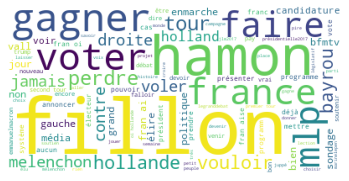

In [56]:
df = df1.copy()
dfmacron = df[df.candidate != 'Lepen']

import wordcloud
from wordcloud import WordCloud, STOPWORDS
all = ' '.join(dfmacron['Clean'])
stopwords = STOPWORDS
l = ['élection', 'pas', 'présidentiel', 'election','candidat','plus', 'presidentielle2017']
for e in l:
    stopwords.add(e)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(all)
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [51]:
!pip3 install  scipy.misc

ERROR: Could not find a version that satisfies the requirement scipy.misc
ERROR: No matching distribution found for scipy.misc
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


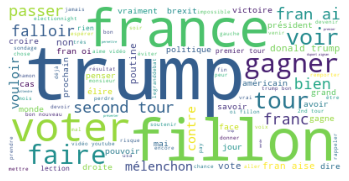

In [53]:
df = df1.copy()
dfmacron = df[df.candidate != 'Macron']

import wordcloud
from wordcloud import WordCloud, STOPWORDS


all = ' '.join(dfmacron['Clean'])
stopwords = STOPWORDS
l = ['élection', 'pas', 'présidentiel', 'election','candidat','plus', 'presidentielle2017']
for e in l:
    stopwords.add(e)
wordcloud = WordCloud(stopwords=stopwords, background_color="#023d4d", max_words=100).generate(all)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# First Visualisation

plots to do

# Model 1: Logistic Regression

In [136]:
#Helpers for logistic regression
def find_link(text):
    links=re.findall(r'http\S+',text)
    return len(links)

def find_quote(text):
    quotes=re.findall(r'\"(.+?)\"',text)
    return len(quotes)

def find_CAPS(text):
    caps=re.findall('[A-Z]',text)
    return len(caps)

def find_hashtag(text):
    h=re.findall('[#]',text)
    return len(h)

def find_exclamation(text):
    e=re.findall('[!]',text)
    return len(e)

def find_interrogation(text):
    q=re.findall('[?]',text)
    return len(q)

In [137]:
df1['links'] = df1['Tweet'].apply(lambda x: find_link(x)) 
df1['quotes'] = df1['Tweet'].apply(lambda x: find_quote(x))
df1['hashtags'] = df1['Tweet'].apply(lambda x: find_hashtag(x))
df1['capslock'] = df1['Tweet'].apply(lambda x: find_CAPS(x))
df1['exclamation'] = df1['Tweet'].apply(lambda x: find_exclamation(x))
df1['interrogation'] = df1['Tweet'].apply(lambda x: find_interrogation(x))
df1['nb_caracter'] = df1['Tweet'].apply(len)

In [138]:
#----------Logistic Regression-------------
dataframe = df1[['links','quotes', 'hashtags', 'capslock', 'exclamation', 'interrogation', 'nb_caracter', 'label']]
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['label'], axis=1), df.label, test_size=0.2, random_state=1234)
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/Users/maay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6099290780141844

# Model 2: CNN

In [21]:

X_train, X_test, y_train, y_test = train_test_split(df1["Clean"].to_numpy(), df1["label"].to_numpy(), test_size=0.25, random_state=1234)

In [22]:
    X_tensor = []
    for matrix in X_train:
        X_temp = []
        for liste in matrix:
            X_temp.append(np.asarray(liste).astype('float32'))
        X_tensor.append(np.asarray(X_temp).astype('float32'))
    X_tensor = np.asarray(X_tensor).astype('float32')
    

    print("X ", X_tensor.shape)
        
    y_tensor = np.asarray(y_train).astype('float32')
    print("y" ,y_tensor.shape)
    
    X_tensor_test = []
    for matrix in X_test:
        X_temp = []
        for liste in matrix:
            X_temp.append(np.asarray(liste).astype('float32'))
        X_tensor_test.append(X_temp)
    X_tensor_test = np.asarray(X_tensor_test).astype('float32')
    print("X ", X_tensor_test.shape)
        
    y_tensor_test = np.asarray(y_test).astype('float32')
    print("y" ,y_tensor_test.shape)
    


X  (1583, 20, 300)
y (1583,)
X  (528, 20, 300)
y (528,)


In [28]:
def CNN(X_train,X_test, y_train, y_test,sentence_size,word_dim):
  
    model = tf.keras.Sequential()

    model.add(layers.Conv1D(200,5,padding='same', activation='relu',input_shape=(sentence_size,word_dim)))

    model.add(layers.Conv1D(50,5,padding='same', activation='relu'))

    model.add(layers.GlobalMaxPooling1D())
    
    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
       
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    history = model.fit(X_train,y_train,batch_size=32,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])  # <- TO UNCOMMENT AND COMPLETE
    model.evaluate(X_test, y_test)

    return model, history


In [29]:
model,history = CNN(X_tensor,X_tensor_test, y_tensor, y_tensor_test,20,300)


Epoch 1/50
50/50 [==============================] - 1s 19ms/step - loss: 0.7002 - accuracy: 0.5910 - val_loss: 0.6552 - val_accuracy: 0.6326
Epoch 2/50
50/50 [==============================] - 1s 16ms/step - loss: 0.6260 - accuracy: 0.6297 - val_loss: 0.6819 - val_accuracy: 0.5549
Epoch 3/50
50/50 [==============================] - 1s 17ms/step - loss: 0.5646 - accuracy: 0.7276 - val_loss: 0.6658 - val_accuracy: 0.6326
Epoch 4/50
50/50 [==============================] - 1s 17ms/step - loss: 0.4361 - accuracy: 0.8219 - val_loss: 0.8040 - val_accuracy: 0.4924
Epoch 5/50
50/50 [==============================] - 1s 16ms/step - loss: 0.3318 - accuracy: 0.8773 - val_loss: 0.7525 - val_accuracy: 0.6288
Epoch 6/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1658 - accuracy: 0.9663 - val_loss: 0.8657 - val_accuracy: 0.5549
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0872 - accuracy: 0.9855 - val_loss: 0.9216 - val_accuracy: 0.5909
Epoch 8/50
50

NameError: name 'plot_graphs' is not defined

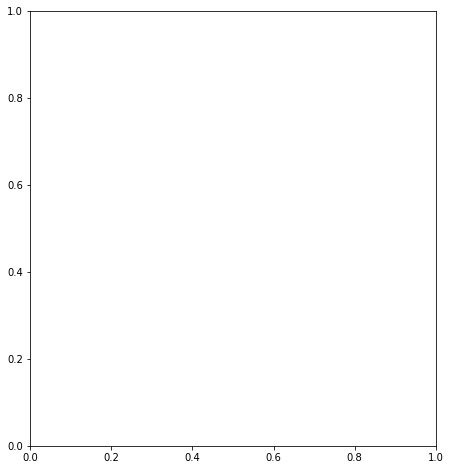

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Model 3: Bert

In [8]:
def to_add(date_str):
    date_str = date_str + ', 2021'
    return date_str
    
def create_data_set(file_name):
    df = pd.read_excel(file_name)
    df['Date'] = df['Date'].apply(to_add)
    df['datetime']=pd.to_datetime(df['Date'])
    df['ts'] = df[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
    df=df.drop(['datetime','Date'],axis=1)
    df['Likes']=df['Likes'].fillna(0)
    df['Retweets']=df['Retweets'].fillna(int(0))
    return df


In [9]:
df2 = create_data_set("LEPEN_new.xlsx")

In [10]:
!pip install transformers>=4.0
!pip install sentencepiece

import tensorflow as tf


In [11]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine", use_fast=True)
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

bert = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

import tensorflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [12]:
df2['label_BERT'] = df2[['Tweet']].apply(lambda x: bert(str(x))[0]["label"], axis=1)


In [13]:
df2['label_BERT'] = df2['label_BERT'].map({'NEGATIVE': 0, 'POSITIVE': 1}).astype(int)

TO DO!!! compute the accuracy of bert by comparing the value of the column 'label' with the column 'label_BERT'

# Plots of the 2021 Dataset

Plots:
<br>
1) on the same plot for both candidates: positive-negative tweets and normalize them ; count retweets ; 0 in the middlge
<br>
2) one for macron ; one for Lepen: plots positive, negative, total as a function of time
<br>

In [14]:
def count_tweets_vs_time(df, candidate):
    date_list = []
    res = []
    i = 0
    while i< len(df["ts"])-1:
        if df["ts"].iloc[i] != df["ts"].iloc[i+1]:
            date_list.append(df["ts"].iloc[i])
            if df["label_BERT"].iloc[i] == 1: #positive
                res.append((1 + int(df["Retweets"].iloc[i]), 0))
            else:
                res.append((0, 1 + int(df["Retweets"].iloc[i])))
                
        else: 
            count_pos  = 0
            count_neg = 0
            while df["ts"].iloc[i] == df["ts"].iloc[i+1]:
                date = df["ts"].iloc[i]
                
                if df["Candidate"].iloc[i] == candidate:
                    if df["label_BERT"].iloc[i] == 1: #positive
                        count_pos +=(1+ int(df["Retweets"].iloc[i]))
                    else: #negative
                        count_neg +=(1+ int(df["Retweets"].iloc[i]))
                
                i+=1
            res.append((count_pos, count_neg))
            date_list.append(date)
        i+=1
    
    if i == len(df["ts"])-1 and df["ts"].iloc[i] != df["ts"].iloc[i-1]:
        date_list.append(df["ts"].iloc[i])
        if df["label_BERT"].iloc[i] == 1: #positive
            res.append((1 + int(df["Retweets"].iloc[i], 0)))
        else:
            res.append((0, 1 + int(df["Retweets"].iloc[i])))
        
                    
    return date_list,res

        

In [15]:
df2 = df2.sort_values(by=['ts'])


In [17]:

def plot1(df1):
    plt.figure()
    plt.title("Sentiment for the candidates as a function of time")
    date_list, res = count_tweets_vs_time(df1,"Macron")
    normalized = [(res[i][0] - res[i][1])/(1 + res[i][0] + res[i][1]) for i in range(len(res))]
    plt.plot(date_list,normalized, label = "Macron")
    date_list, res = count_tweets_vs_time(df1,"Lepen")
    normalized = [(res[i][0] - res[i][1])/(1 + res[i][0] + res[i][1]) for i in range(len(res))]
    plt.plot(date_list,normalized, label = "Lepen")
    plt.legend()
    plt.show()

In [1]:
from datetime import datetime

timestamp = 1619*(10**9)
dt_object = datetime.fromtimestamp(timestamp)


ValueError: year 53274 is out of range

In [20]:
timestamp = 1619827200
temp = datetime.fromtimestamp(timestamp)
print(temp)


2021-05-01 02:00:00


In [18]:
from datetime import datetime

def plot2(df2, candidate):
    plt.figure()
    plt.figure(figsize=(5, 5))
    plt.title("Sentiment for the candidates in 2021 ")
    df2 = df2.sort_values(by=['ts'])
    date_list, res = count_tweets_vs_time(df2,candidate) 
    normalized = [(res[i][0] - res[i][1]) for i in range(len(res))]
    print(date_list)
    print(res)
    plt.plot(date_list,normalized, label = candidate)
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('Positive - negative')
    plt.show()

[1610409600, 1610755200, 1611100800, 1611273600, 1611360000, 1611532800, 1611619200, 1611705600, 1611792000, 1611878400, 1611964800, 1612051200, 1612137600, 1612224000, 1612310400, 1612396800, 1612483200, 1612569600, 1612656000, 1612742400, 1612828800, 1612915200, 1613001600, 1613088000, 1613174400, 1613260800, 1613347200, 1613433600, 1613520000, 1613606400, 1613692800, 1613779200, 1613865600, 1613952000, 1614038400, 1614124800, 1614211200, 1614297600, 1614384000, 1614470400, 1614556800, 1614643200, 1614729600, 1614816000, 1614902400, 1614988800, 1615075200, 1615161600, 1615248000, 1615334400, 1615420800, 1615507200, 1615593600, 1615680000, 1615766400, 1615852800, 1615939200, 1616025600, 1616112000, 1616198400, 1616284800, 1616371200, 1616457600, 1616544000, 1616630400, 1616716800, 1616803200, 1616889600, 1616976000, 1617062400, 1617148800, 1617235200, 1617321600, 1617408000, 1617494400, 1617580800, 1617667200, 1617753600, 1617840000, 1617926400, 1618012800, 1618099200, 1618185600, 161

<Figure size 432x288 with 0 Axes>

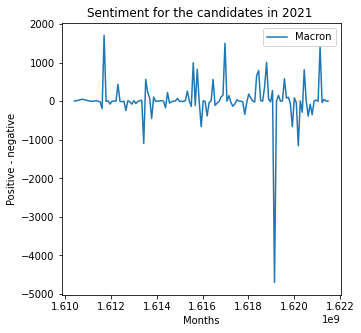

In [19]:
plot2(df2,"Macron")

In [291]:
def plot3(df, candidate):
    plt.figure()
    plt.title("Sentiment for Macron in 2021")
    date_list, res = count_tweets_vs_time(df2,candidate)
    print(date_list[0])
    positive = [res[i][0] for i in range(len(res))]
    plt.plot(date_list,positive, label = "positive")
    negative = [res[i][1] for i in range(len(res))]
    plt.plot(date_list,negative, label = "negative")
    plt.xlabel('Months')
    plt.ylabel('Total Tweets')
    plt.legend()
    plt.show()

1610409600


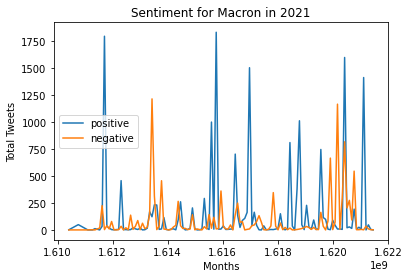

1610409600


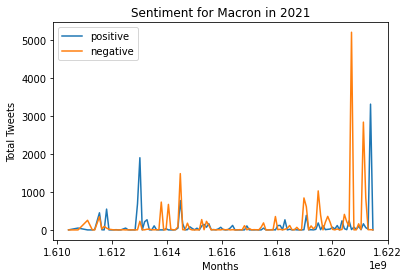

In [292]:
plot3(df2, "Macron")
plot3(df2, "Lepen")

# Plots of the 2021 Dataset

In [ ]:
def create_data_set_with_bert(file_name,bert):
    df = pd.read_excel(file_name)
    df['datetime']=pd.to_datetime(df['Date'])
    df['ts'] = df[['datetime']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
    df=df.drop(['datetime','Date'],axis=1)
    df['label'] = df1[['Tweet']].apply(lambda x: bert(str(x))[0]["label"], axis=1) #we use BERT Model
    df['label'] = df['label'].map({'NEGATIVE': 0, 'POSITIVE': 1}).astype(int)
    df['Likes']=df['Likes'].fillna(0)
    df['Retweets']=df['Retweets'].fillna(int(0))
    return df

In [290]:
#creatde Dataset
filename = " "#to add
df2 = create_data_set_with_bert(filename,bert) #column label is filled with BERT this time
df2 = df2.sort_values(by=['ts'])

plot1(df1)

plot2(df1, "Lepen")
plot2(df1,"Macron")

plot3(df1, "Macron")
plot3(df1, "Lepen")

FileNotFoundError: [Errno 2] No such file or directory: ' '